In [17]:
import numpy as np
import sklearn
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler

from tslearn.datasets import UCR_UEA_datasets
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pyts.datasets import fetch_ucr_dataset

np.set_printoptions(threshold=10_000)


In [30]:
int(150/4)

37

In [45]:
# Implement methods required by DataLoader
class UCRDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label


# Define the CNN Model
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel (grayscale), 32 output channels
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce size by half
        self.fc1 = nn.Linear(64 * 71, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        self.features = x  # Save the features before flattening for Grad-CAM
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

# Training Loop
def train(model, loader, criterion, optimizer, device, num_epochs = 20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(loader):.4f}")


# Test Function
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += 1
            correct += (predicted == torch.max(labels.reshape(1, -1), 1)[1]).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


# Classification Function
def classify(model, sample, device):
    model.eval()
    with torch.no_grad():
        image = torch.from_numpy(sample[0]).to(device).unsqueeze(0)  # Add batch dimension
        output = model(image)

        predicted = np.zeros(len(sample[1]))
        _, ind = torch.max(output, 1)
        predicted[ind] = 1.0
    return predicted


def grad_cam(model, input_tensor, target_class):
    model.eval()  # Set model to evaluation mode

    # Create storage for gradients
    gradients = {}

    # Register hook to capture gradients from conv2
    def save_gradients(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]

    # Hook the conv2 layer
    model.conv2.register_backward_hook(save_gradients)

    # Forward pass
    output = model(input_tensor)

    # Get the score for the target class
    score = output[:, target_class]

    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward(retain_graph=True)

    # Extract gradients and feature maps
    activations = model.features.detach()  # Feature maps
    grads = gradients["value"].detach()  # Gradients w.r.t the feature maps

    # Compute weights (global average pooling of gradients)
    weights = torch.mean(grads, dim=2, keepdim=True)  # Average over time dimension

    # Compute Grad-CAM activation map
    grad_cam_map = torch.sum(weights * activations, dim=1).squeeze()  # Weighted sum of feature maps
    ### grad_cam_map = abs(grad_cam_map) ### 
    grad_cam_map = F.relu(grad_cam_map)  # Apply ReLU to keep only positive contributions

    # Upsample Grad-CAM map to match input size
    grad_cam_map = F.interpolate(
        grad_cam_map.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(input_tensor.size(2)),  # Match the input time series length
        mode="linear",
        align_corners=False,
    ).squeeze()  # Remove extra dimensions

    # Normalize the Grad-CAM map
    grad_cam_map = grad_cam_map - grad_cam_map.min()
    grad_cam_map = grad_cam_map / grad_cam_map.max()
    return grad_cam_map.cpu().numpy()


# Plot single Time Series with Label
def plot_ts(ts_sample):
    ts, label = ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts[0], label="Time Series", color='blue')
    plt.title(f"Time Series Plot (Class Label: {label})")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


# Plot all Time Series
def plot_all_ts(test_dataset):
    plt.figure(figsize=(10, 4))
    for item in test_dataset:
        ts, label = item
        color = 'blue' if label[0] == 1 else 'orange'
        plt.plot(ts[0], label="Time Series", color=color)
    plt.title(f"All Time Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, traindata.shape[1], 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, testdata.shape[1], 1)
    return scaled_traindata, scaled_testdata


def get_areas(above_threshold):

    areas = []
    start = None
    end = None
    for i, j in enumerate(above_threshold):
        if j & (start is None):
            start = i
        if (not j) & (start is not None):
            end = i
            areas.append([start, end])
            start = None
            end = None

    if start is not None:
        areas.append([start, len(above_threshold)])

    return areas


def generate_random_areas(total_length, number, size):
  
    if number * size > total_length:
        raise ValueError("Cannot fit the requested number of areas of the given size within the total length.")
    
    areas = []
    available_indices = list(range(total_length))  # All possible indices
    
    while len(areas) < number:
        start = random.choice(available_indices)  # Randomly pick a starting point
        end = start + size

        # Check if the area fits within the time series
        if end > total_length:
            continue

        # Check if the area overlaps with any existing area
        overlap = any(max(start, existing[0]) < min(end, existing[1]) for existing in areas)
        if overlap:
            continue

        # If no overlap, add the area and remove these indices from the pool
        areas.append([start, end])
        available_indices = [i for i in available_indices if i < start or i >= end]

    areas.sort(key=lambda x: x[0])
    
    return areas


def time_series_to_zero(ts, start, end):
    out = ts.copy()
    out[start:end] = 0
    return out


def time_series_interpolate_linear(ts, start, end):
     out = ts.copy()
     out[start:end] = np.interp(list(range(start, end)), [start, end], [out[start][0], out[end][0]]).reshape(end - start,1)
     return out


def time_series_to_mean(ts, start, end, data):
    out = ts.copy()
    out[start:end] = np.array([np.mean([ts[i] for ts in data]) for i in range(start, end)]).reshape(end - start,1)
    return out


def cancel_time_series(ts, start, end, data, how="mean"):
    out = ts.copy()
    if how == "mean":
        out[start:end] = np.array([np.mean([ts[i] for ts in data]) for i in range(start, end)]).reshape(end - start,1)
    if how == "linear":
        out[start:end] = np.interp(list(range(start, end)), [start, end], [out[start][0], out[end][0]]).reshape(end - start,1)
    if how == "zero":
        out[start:end] = 0
    return out


def create_sample(test_id, areas, data="test", how="mean", invert=False):

    train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset("Coffee")
    train_x, test_x = scale_dataset(train_x, test_x)

    d = test_x if data == "test" else train_x
    sample_x = d[test_id]

    if invert:
        inverted = []
        previous_end = 0

        for start, end in areas:
            if start > previous_end:
                inverted.append([previous_end, start])
            previous_end = end

        if previous_end < len(sample_x):
            inverted.append([previous_end, len(sample_x)])

        areas = inverted

    for start, end in areas:
        sample_x = cancel_time_series(sample_x, start, end, d, how=how)

    sample_y = test_y[test_id]

    sample_x = sample_x.reshape(-1, 1, train_x.shape[-2])

    enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
    sample_y=enc1.transform(sample_y.reshape(-1,1))

    sample = UCRDataset(sample_x.astype(np.float32),sample_y.astype(np.float32))

    return sample


In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BasicCNN(num_classes=2).to(device)

In [27]:
summary(model, (1, 286))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 286]             128
         MaxPool1d-2              [-1, 32, 143]               0
            Conv1d-3              [-1, 64, 143]           6,208
         MaxPool1d-4               [-1, 64, 71]               0
            Linear-5                  [-1, 128]         581,760
            Linear-6                    [-1, 2]             258
           Softmax-7                    [-1, 2]               0
Total params: 588,354
Trainable params: 588,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 2.24
Estimated Total Size (MB): 2.46
----------------------------------------------------------------


In [35]:
datasets = [{"name": "GunPoint", "[1. 0.]": "Gun", "[0. 1.]": "No Gun"}, 
            {"name": "Coffee", "[1. 0.]": "Robusta", "[0. 1.]": "Arabica"}]

train_x, test_x, train_y, test_y = fetch_ucr_dataset(datasets[1]["name"], return_X_y = True)
train_x, test_x = scale_dataset(train_x, test_x)

enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Data Preparation (using MNIST as an example)

# train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset("Coffee")

# # Scale dataset
# train_x, test_x = scale_dataset(train_x, test_x)

train_x = train_x.reshape(-1, 1, train_x.shape[-2])
test_x = test_x.reshape(-1, 1, test_x.shape[-2])

# enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))

# train_y=enc1.transform(train_y.reshape(-1,1))
# test_y=enc1.transform(test_y.reshape(-1,1))

train_dataset = UCRDataset(train_x.astype(np.float32),train_y.astype(np.float32))
test_dataset = UCRDataset(test_x.astype(np.float32),test_y.astype(np.float32))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [46]:
# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
train(model, train_loader, criterion, optimizer, device, num_epochs=100)

Epoch [1/100], Loss: 0.8328
Epoch [2/100], Loss: 0.8453
Epoch [3/100], Loss: 0.7049
Epoch [4/100], Loss: 0.6986
Epoch [5/100], Loss: 0.6937
Epoch [6/100], Loss: 0.6961
Epoch [7/100], Loss: 0.6943
Epoch [8/100], Loss: 0.6936
Epoch [9/100], Loss: 0.6932
Epoch [10/100], Loss: 0.6930
Epoch [11/100], Loss: 0.6939
Epoch [12/100], Loss: 0.6914
Epoch [13/100], Loss: 0.6884
Epoch [14/100], Loss: 0.6846
Epoch [15/100], Loss: 0.6743
Epoch [16/100], Loss: 0.6674
Epoch [17/100], Loss: 0.6453
Epoch [18/100], Loss: 0.6293
Epoch [19/100], Loss: 0.5716
Epoch [20/100], Loss: 0.5282
Epoch [21/100], Loss: 0.5243
Epoch [22/100], Loss: 0.4530
Epoch [23/100], Loss: 0.4530
Epoch [24/100], Loss: 0.4042
Epoch [25/100], Loss: 0.3957
Epoch [26/100], Loss: 0.3802
Epoch [27/100], Loss: 0.3675
Epoch [28/100], Loss: 0.3551
Epoch [29/100], Loss: 0.3686
Epoch [30/100], Loss: 0.3562
Epoch [31/100], Loss: 0.3524
Epoch [32/100], Loss: 0.3333
Epoch [33/100], Loss: 0.3318
Epoch [34/100], Loss: 0.3409
Epoch [35/100], Loss: 0

In [47]:
# Testing
test(model, test_loader, device)

# Example Classification
# Assuming `example_image` is a single MNIST image preprocessed similarly to the training data
test_sample = test_dataset[15]
predicted_label = classify(model, test_sample, device)
print(f"Predicted Label: {predicted_label}")


Test Accuracy: 100.00%
Predicted Label: [0. 1.]


In [369]:
np.argmax(model(torch.from_numpy(test_x).float()).detach().numpy(), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [370]:
test_dataset.target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

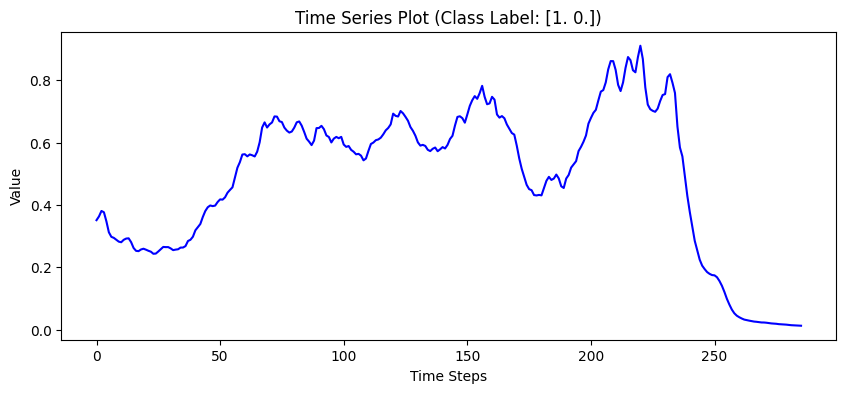

In [371]:
plot_ts(test_dataset[0])

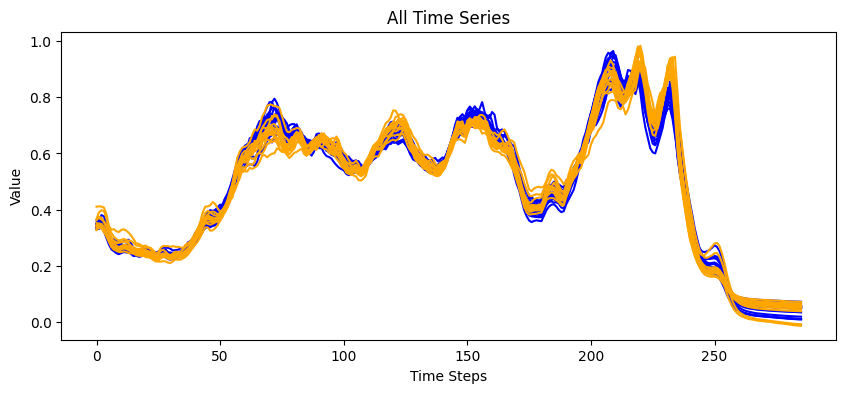

In [372]:
plot_all_ts(test_dataset)

In [429]:
input_tensor = torch.from_numpy(test_dataset[17][0]).to(device).unsqueeze(0)

model.eval()  # Set model to evaluation mode

# Create storage for gradients
gradients = {}

# Register hook to capture gradients from conv2
def save_gradients(module, grad_in, grad_out):
    gradients["value"] = grad_out[0]

# Hook the conv2 layer
model.conv2.register_backward_hook(save_gradients)

# Forward pass
output = model(input_tensor)

# Get the score for the target class
score = output[:, 1]

# Backward pass to calculate gradients
model.zero_grad()
score.backward(retain_graph=True)

# Extract gradients and feature maps
activations = model.features.detach()  # Feature maps
grads = gradients["value"].detach()  # Gradients w.r.t the feature maps

# Compute weights (global average pooling of gradients)
weights = torch.mean(grads, dim=2, keepdim=True)  # Average over time dimension

# Compute Grad-CAM activation map
grad_cam_map = torch.sum(weights * activations, dim=1).squeeze()  # Weighted sum of feature maps
# grad_cam_map = F.relu(grad_cam_map)  # Apply ReLU to keep only positive contributions

# # Upsample Grad-CAM map to match input size
# grad_cam_map = F.interpolate(
#     grad_cam_map.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
#     size=(input_tensor.size(2)),  # Match the input time series length
#     mode="linear",
#     align_corners=False,
# ).squeeze()  # Remove extra dimensions

# # Normalize the Grad-CAM map
# grad_cam_map = grad_cam_map - grad_cam_map.min()
# grad_cam_map = grad_cam_map / grad_cam_map.max()

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
weights.cpu().detach().numpy()
# Keine positiven Gewichte (Gradienten)!!

array([[[ 0.0000000e+00],
        [ 0.0000000e+00],
        [-1.0734296e-06],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [-9.5152835e-08],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [-1.4558555e-06],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [-2.3200146e-06],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [-1.7308594e-06],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [-2.3980674e-06],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


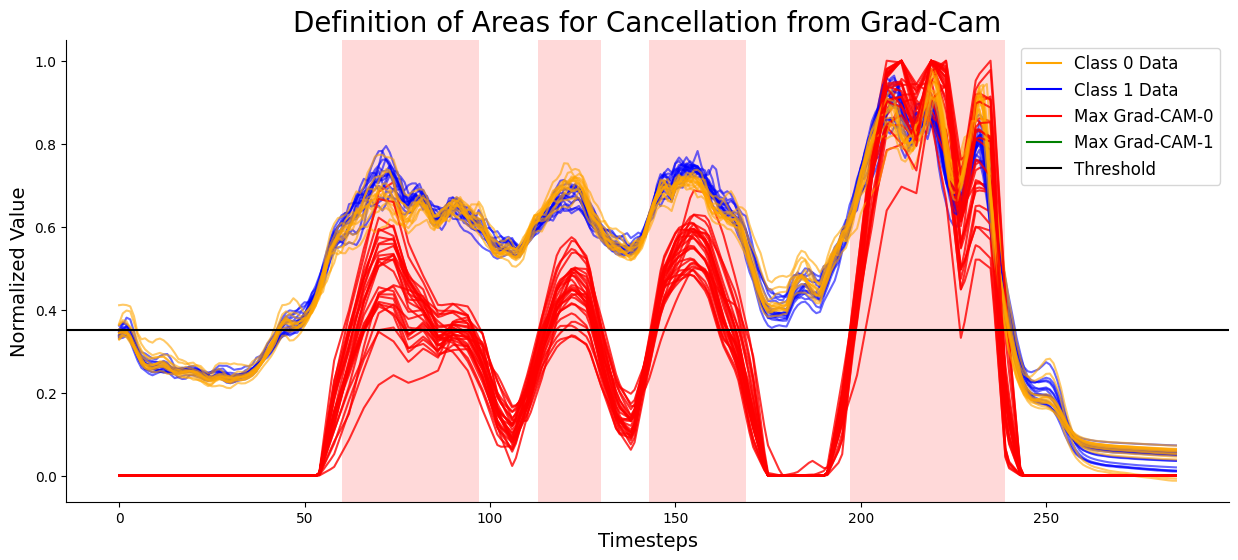

In [55]:
time_axis = np.arange(286)
plt.figure(figsize=(15, 6))

# Initialize arrays for Grad-CAM maxima
max_cam_0 = np.zeros_like(time_axis, dtype=float)
max_cam_1 = np.zeros_like(time_axis, dtype=float)

for sample in test_dataset:
    input_tensor = torch.from_numpy(sample[0]).to(device).unsqueeze(0)
    label = sample[1]

    # Visualization
    color = 'blue' if label[0] == 1 else 'orange'
    plt.plot(time_axis, input_tensor.squeeze().detach().numpy(), label="Input Time Series", color=color, alpha=0.6)

    # Compute Grad-CAM for class 0
    cam_0 = grad_cam(model, input_tensor, 0)
    max_cam_0 = np.fmax(max_cam_0, cam_0)
    plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

    # Compute Grad-CAM for class 1
    cam_1 = grad_cam(model, input_tensor, 1)
    max_cam_1 = np.fmax(max_cam_1, cam_1)
    plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")

# Replace multiple Grad-CAM lines with their respective maxima
# plt.plot(time_axis, max_cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")
# plt.plot(time_axis, max_cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")

# Add grey shaded areas where Grad-CAM max values exceed the threshold
threshold = 0.35
above_threshold_0 = max_cam_0 > threshold
above_threshold_1 = max_cam_1 > threshold

# Combine the regions for shading
above_threshold = np.logical_or(above_threshold_0, above_threshold_1)

for i in range(1, len(time_axis)):
    if above_threshold_0[i]:
        plt.axvspan(time_axis[i - 1], time_axis[i], color='red', alpha=0.15, lw=0)

for i in range(1, len(time_axis)):
    if above_threshold_1[i]:
        plt.axvspan(time_axis[i - 1], time_axis[i], color='green', alpha=0.15, lw=0)

plt.axhline(y=threshold, color="black")

# Add title, labels, and legend
plt.title("Definition of Areas for Cancellation from Grad-Cam", fontdict = {'fontsize' : 20})
plt.xlabel("Timesteps", fontdict = {'fontsize' : 14})
plt.ylabel("Normalized Value", fontdict = {'fontsize' : 14})

colors = ['orange', 'blue', 'red', 'green', 'black']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Class 0 Data', 'Class 1 Data', 'Max Grad-CAM-0', 'Max Grad-CAM-1', 'Threshold']
plt.legend(lines, labels, prop={'size': 12})

# Hide the top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("images/Definition of Areas for Cancellation from Grad-Cam.png")
plt.show()


In [467]:
areas_0 = get_areas(above_threshold_0)

In [531]:
areas_0 = generate_random_areas(286, 4, 20)

In [535]:
sample = create_sample(17, areas_0, data="test", how="zero", invert=True)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


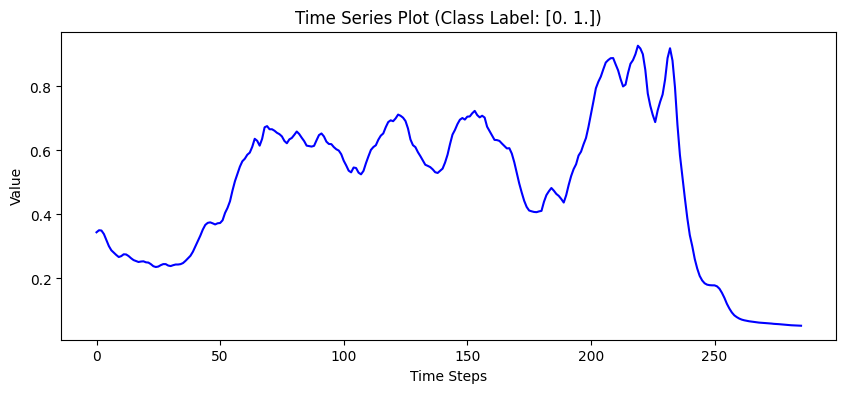

In [356]:
plot_ts(test_dataset[17])

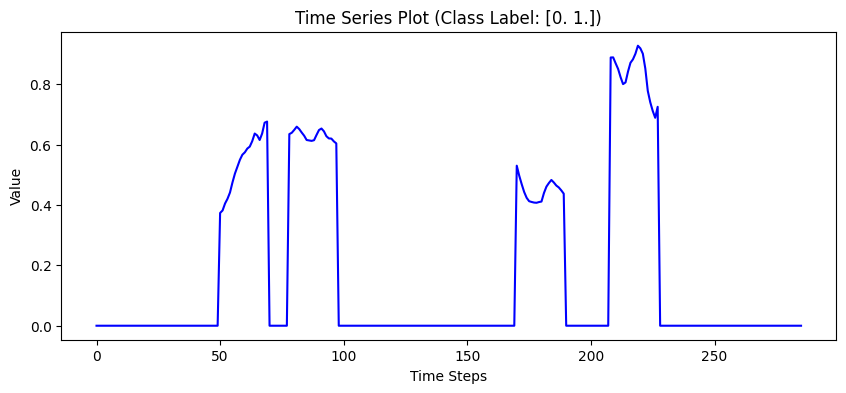

In [536]:
plot_ts(sample[0])

In [454]:
# Example Classification
test_sample = test_dataset[17]
predicted_label = classify(model, test_sample, device)
print(f"Predicted Label: {predicted_label}")

Predicted Label: [0. 1.]


In [442]:
test_sample = sample[0]
predicted_label = classify(model, test_sample, device)
print(f"Predicted Label: {predicted_label}")

Predicted Label: [1. 0.]


In [455]:
model.eval()
output = model(torch.from_numpy(test_dataset[17][0]).to(device).unsqueeze(0))
output

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([[2.3761e-04, 9.9976e-01]], grad_fn=<SoftmaxBackward0>)

In [461]:
model.eval()
output = model(torch.from_numpy(sample[0][0]).to(device).unsqueeze(0))
output

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([[0.0051, 0.9949]], grad_fn=<SoftmaxBackward0>)

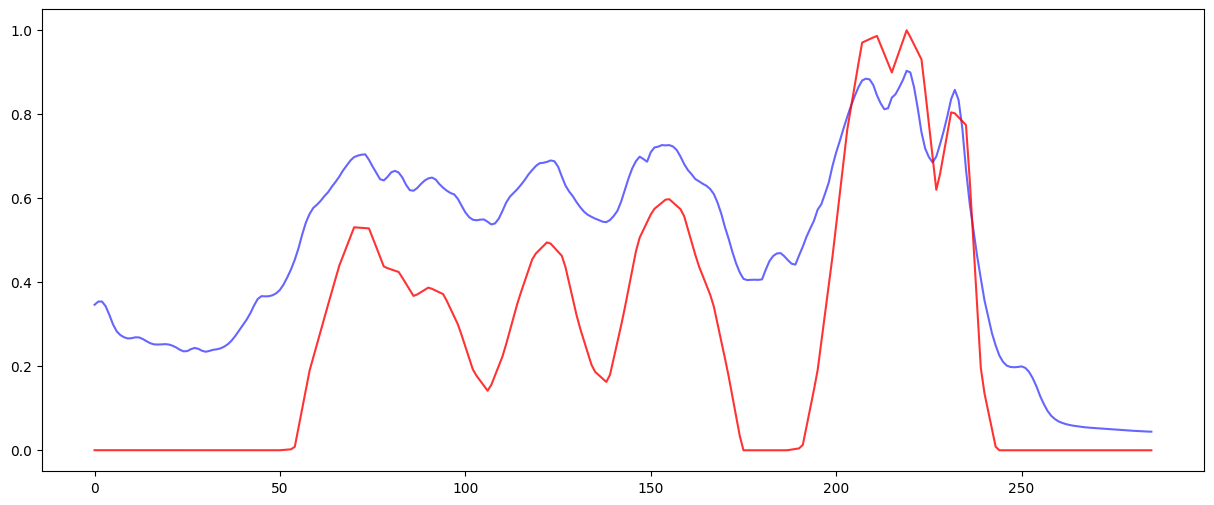

In [445]:
input_tensor = torch.from_numpy(sample[0][0]).to(device).unsqueeze(0)

# Visualization
time_axis = np.arange(286)
plt.figure(figsize=(15, 6))
plt.plot(time_axis, input_tensor.squeeze().detach().numpy(), label="Input Time Series", color='blue', alpha=0.6)

# Compute Grad-CAM for class 0
cam_0 = grad_cam(model, input_tensor, 0)
plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

# Compute Grad-CAM for class 1
cam_1 = grad_cam(model, input_tensor, 1)
plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")

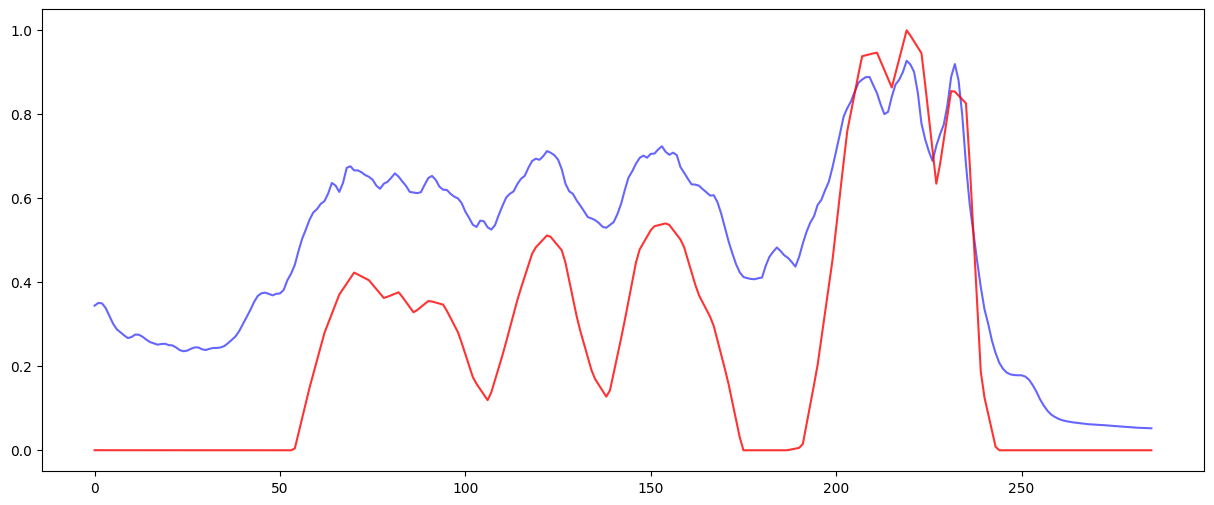

In [446]:
input_tensor = torch.from_numpy(test_dataset[17][0]).to(device).unsqueeze(0)

# Visualization
time_axis = np.arange(286)
plt.figure(figsize=(15, 6))
plt.plot(time_axis, input_tensor.squeeze().detach().numpy(), label="Input Time Series", color='blue', alpha=0.6)

# Compute Grad-CAM for class 0
cam_0 = grad_cam(model, input_tensor, 0)
plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

# Compute Grad-CAM for class 1
cam_1 = grad_cam(model, input_tensor, 1)
plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")